In [1]:
!git clone https://github.com/nazianafis/Brain-MRI-Classification.git

Cloning into 'Brain-MRI-Classification'...
remote: Enumerating objects: 3125, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 3125 (delta 29), reused 75 (delta 23), pack-reused 3042 (from 1)
Receiving objects: 100% (3125/3125), 83.50 MiB | 29.48 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (3291/3291), done.


In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# For performance evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools


In [3]:
base_train_dir = "/content/Crop-Brain-MRI"
base_test_dir = "/content/Test-Brain-MRI"
classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

for base_dir in [base_train_dir, base_test_dir]:
    os.makedirs(base_dir, exist_ok=True)
    for cls in classes:
        os.makedirs(os.path.join(base_dir, cls), exist_ok=True)


In [4]:
def crop_image(image, plot=False):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5,5), 0)
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    if contours:
        c = max(contours, key=cv2.contourArea)
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
        if plot:
            plt.figure(figsize=(8,4))
            plt.subplot(1,2,1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title("Original Image")
            plt.axis('off')
            plt.subplot(1,2,2)
            plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
            plt.title("Cropped Image")
            plt.axis('off')
            plt.show()
        return new_image
    else:
        return image


In [5]:
original_train_dir = "/content/Brain-MRI-Classification/Brain-MRI/Training/"
original_test_dir = "/content/Brain-MRI-Classification/Brain-MRI/Testing/"

for cls in classes:
    src_dir = os.path.join(original_train_dir, cls)
    dst_dir = os.path.join(base_train_dir, cls)
    for j, img_name in enumerate(tqdm(os.listdir(src_dir), desc=f"Cropping Training {cls}")):
        img_path = os.path.join(src_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            cropped = crop_image(img)
            resized = cv2.resize(cropped, (224,224))
            cv2.imwrite(os.path.join(dst_dir, f"{j}.jpg"), resized)

for cls in classes:
    src_dir = os.path.join(original_test_dir, cls)
    dst_dir = os.path.join(base_test_dir, cls)
    for j, img_name in enumerate(tqdm(os.listdir(src_dir), desc=f"Cropping Testing {cls}")):
        img_path = os.path.join(src_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            cropped = crop_image(img)
            resized = cv2.resize(cropped, (224,224))
            cv2.imwrite(os.path.join(dst_dir, f"{j}.jpg"), resized)


Cropping Testing pituitary_tumor: 100%|██████████| 5/5 [00:00<00:00, 155.05it/s]


In [6]:
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_data = datagen.flow_from_directory(base_train_dir,
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training',
                                         shuffle=True)

valid_data = datagen.flow_from_directory(base_train_dir,
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation',
                                         shuffle=True)

test_datagen = ImageDataGenerator()

test_data = test_datagen.flow_from_directory(base_test_dir,
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='categorical',
                                             shuffle=False)


Found 2613 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [7]:
effnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = effnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=effnet.input, outputs=output)


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [9]:
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)


In [10]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=valid_data,
                    callbacks=[checkpoint, earlystop],
                    verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5022 - loss: 1.1356
Epoch 1: val_accuracy improved from -inf to 0.81135, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.5041 - loss: 1.1323 - val_accuracy: 0.8113 - val_loss: 0.5456
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8452 - loss: 0.4422
Epoch 2: val_accuracy improved from 0.81135 to 0.89417, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 537ms/step - accuracy: 0.8455 - loss: 0.4414 - val_accuracy: 0.8942 - val_loss: 0.3199
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9107 - loss: 0.2370
Epoch 3: val_accuracy improved from 0.89417 to 0.90491, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 546ms/step - accuracy: 0.9108 - loss: 0.2368 - val_accuracy: 0.9049 - val_loss: 0.2608
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9455 - loss: 0.1664
Epoch 4: val_accuracy improved from 0.90491 to 0.92945, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 532ms/step - accuracy: 0.9456 - loss: 0.1664 - val_accuracy: 0.9294 - val_loss: 0.2114
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9631 - loss: 0.1243
Epoch 5: val_accuracy improved from 0.92945 to 0.94785, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 537ms/step - accuracy: 0.9631 - loss: 0.1242 - val_accuracy: 0.9479 - val_loss: 0.1557
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9783 - loss: 0.0793
Epoch 6: val_accuracy improved from 0.94785 to 0.96472, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 543ms/step - accuracy: 0.9782 - loss: 0.0793 - val_accuracy: 0.9647 - val_loss: 0.1177
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9752 - loss: 0.0701
Epoch 7: val_accuracy improved from 0.96472 to 0.96933, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 530ms/step - accuracy: 0.9752 - loss: 0.0701 - val_accuracy: 0.9693 - val_loss: 0.1058
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9803 - loss: 0.0718
Epoch 8: val_accuracy improved from 0.96933 to 0.97393, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 542ms/step - accuracy: 0.9803 - loss: 0.0718 - val_accuracy: 0.9739 - val_loss: 0.0974
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9890 - loss: 0.0422
Epoch 9: val_accuracy did not improve from 0.97393
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 517ms/step - accuracy: 0.9889 - loss: 0.0423 - val_accuracy: 0.9739 - val_loss: 0.1012
Epoch 10/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9923 - loss: 0.0313
Epoch 10: val_accuracy improved from 0.97393 to 0.98006, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 544ms/step - accuracy: 0.9923 - loss: 0.0313 - val_accuracy: 0.9801 - val_loss: 0.0888
Restoring model weights from the end of the best epoch: 10.


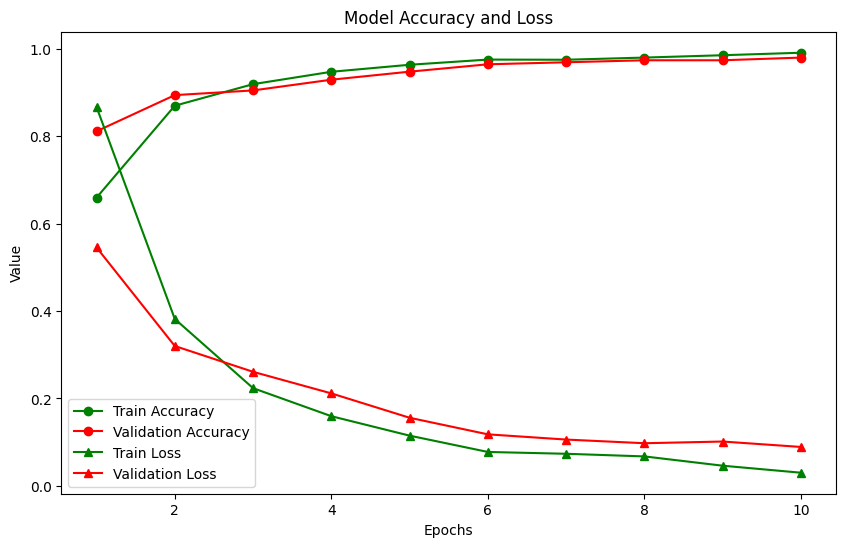

In [11]:
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs_range, history.history['accuracy'], 'go-', label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.plot(epochs_range, history.history['loss'], 'g^-', label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], 'r^-', label='Validation Loss')
plt.title('Model Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [12]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 1.0000 - loss: 0.0071
Test Loss: 0.0071 | Test Accuracy: 1.0000


In [13]:
y_prob = model.predict(test_data)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_data.classes
labels = list(train_data.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels, digits=4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
                  precision    recall  f1-score   support

    glioma_tumor     1.0000    1.0000    1.0000         5
meningioma_tumor     1.0000    1.0000    1.0000         5
        no_tumor     1.0000    1.0000    1.0000         5
 pituitary_tumor     1.0000    1.0000    1.0000         5

        accuracy                         1.0000        20
       macro avg     1.0000    1.0000    1.0000        20
    weighted avg     1.0000    1.0000    1.0000        20



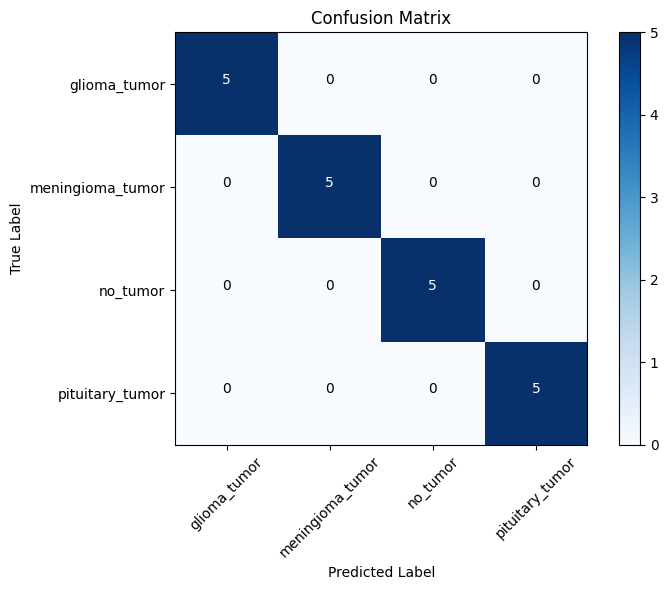

In [14]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]:.2f}" if normalize else f"{cm[i,j]}",
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thresh else 'black')

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, labels)


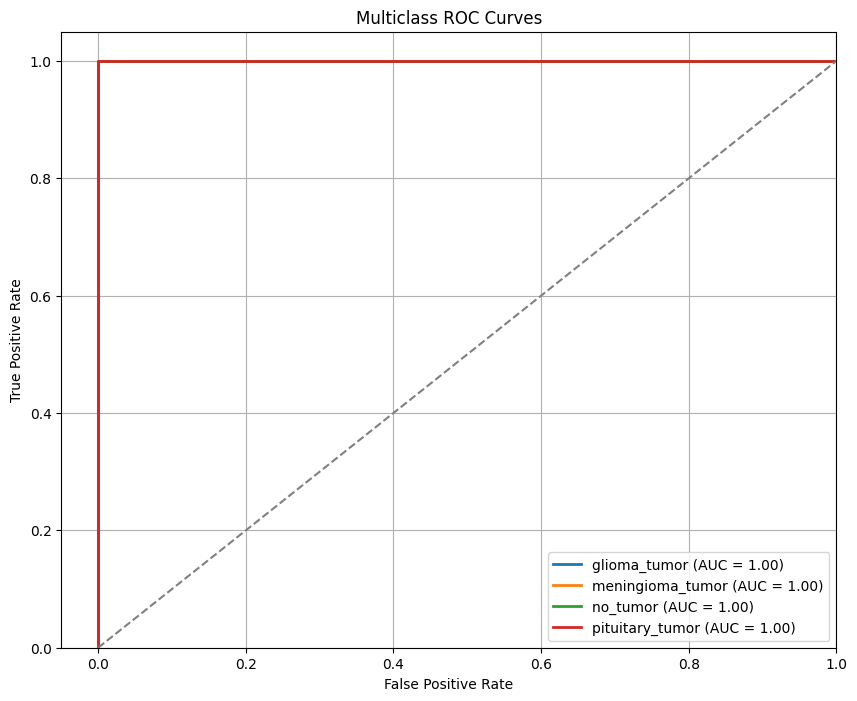

In [15]:
y_true_bin = label_binarize(y_true, classes=range(len(labels)))
fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(10,8))
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


TypeError: Image data of dtype object cannot be converted to float

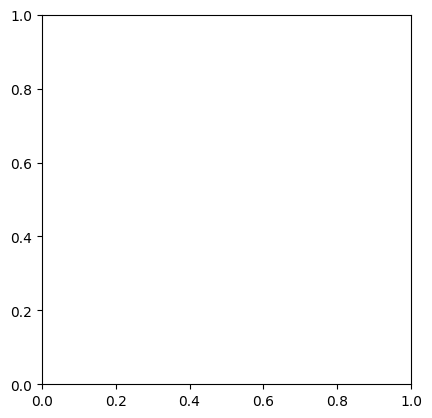

In [3]:
# Obtain Prediction on Test Image
import cv2
import matplotlib.pyplot as plt

class_dict = {0: "glioma_tumor", 1: "meningioma_tumor", 2: "no_tumor", 3: "pituitary_tumor"}

test_img1 = cv2.imread("/content/Test-Brain-MRI/meningioma_tumor/4.jpg")

plt.imshow(test_img1)

plt.grid(False)

test_img1 = np.expand_dims(test_img1, axis=0)

pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class =class_dict[pred]
print(pred_class)

In [4]:
!ls

sample_data
